# Time Series Fundamentals in TensorFlow
> Notebook demonstrates Time series fundamentals in Tensorflow.

- toc: true 
- badges: true
- comments: true
- categories: [DeepLearning, NeuralNetworks, TensorFlow, Time-Series-Data]
- image: images/time_series.png

## Examples of Time Series problems:  
All Time-series data has Temporal(time) component.   
* **Classification:**  
Which of the points is an anomaly?  
Are the heart beats regular?  
Here, the output is **discrete**

* **Forecasting:**  
How much will the price of Bitcoin change tomorrow?  
How many computers will we sell next year?  
How many staff do we need for next week?  
Here, the output is **continuous**






This Blogpost covers the following:  
* Downloading and formatiing time series data(the historical price of Bitcoin)  
* Writing up preprocessing function to prepare our time series data
* Setting up multiple time series modelling experiments.  
* Building a multivariate model to take in multivariate time series data.
* Replicating the N-BEATS algorithm using TensorFlow.
* Making forecasts with prediction intervals.
* Demonstrating why time series forecasting can be not fruitful with the turkey problem.

## Get data

We're going to be using the historical price data of Bitcoin to try and predict the future price of Bitcoin. We downloaded the data from CoinDesk!

In [1]:
#Downloading the dataset using wget command
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv


--2022-06-12 05:45:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.01s   

2022-06-12 05:45:30 (14.0 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Importing the Time series data with Pandas

In [2]:
# Import with pandas
import pandas as pd
# Let's read our bitcoin data and parse the data
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates = ["Date"],
                 index_col = ["Date"]) # Parse the date column and tell pandas the 1st column is date-time data
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
df.tail()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292
2021-05-17,BTC,45604.615754,46805.537852,49670.414174,43868.638969
2021-05-18,BTC,43144.471291,46439.336570,46622.853437,42102.346430


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [5]:
# How many samples are there
len(df)

2787

We've collected thie historical price of Bitcoin for the past ~8 years but there's only 2787 samples.

Typically deep learning models usually like lots and lots of samples (where lots can be thousands to millions)

A smaller number of samples is something you'll often run into with time series data problems.

> **Note:** The **seasonality** of a time series data is referred to as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.


## Types of Time-series:  

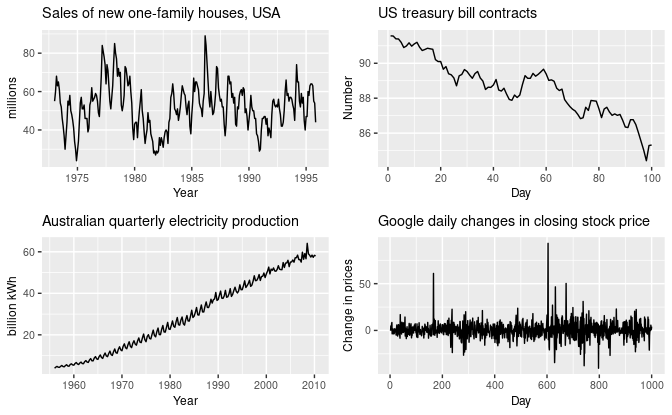  
Source : [Forecasting principles and practices](https://otexts.com/fpp2/tspatterns.html)

**Trend:** -- time series has a clear long-term increase or decrease(may or may not be linear)

**Seasonal:** -- time series affected by seasonal factors such as time of year (e.g. increased sales towards end of year) or day of week

**Cyclic:** -- time series shows rises and falls over an unfixed period, these tend to be longer/more variable than seasonal patterns

**Other types of Time-series data:**  
**Univariate Time-series data:** Only one variable (using the price of Bitcoin to predict the price of Bitcoin)  
**Multivariate Time-series data:** More than one variable (using the price of Bitcoin as well as the block reward size to predic the price of BTC)

## Visualization of our Dataset:


In [6]:
# Only want the closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns = {"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


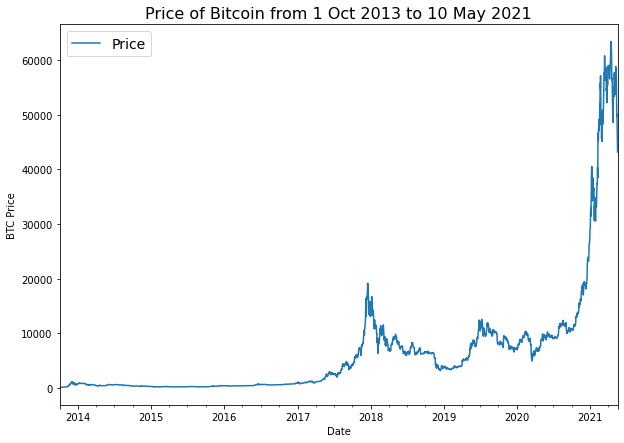

In [7]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize = (10,7))
# Labelling 
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 10 May 2021", fontsize = 16)
plt.legend(fontsize = 14);


## Importing time series data with Python's CSV Module

In [8]:
# Importing and formatting historical Bitcoin data with python
import csv
from csv import reader
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter = ",")
  next(csv_reader) # Skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # Get the dates as dates not strings
    btc_price.append(float(line[2])) # Get closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]


([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Text(0.5, 1.0, 'Price of Bitcoin from 1 Oct 2013 to 10 May 2021')

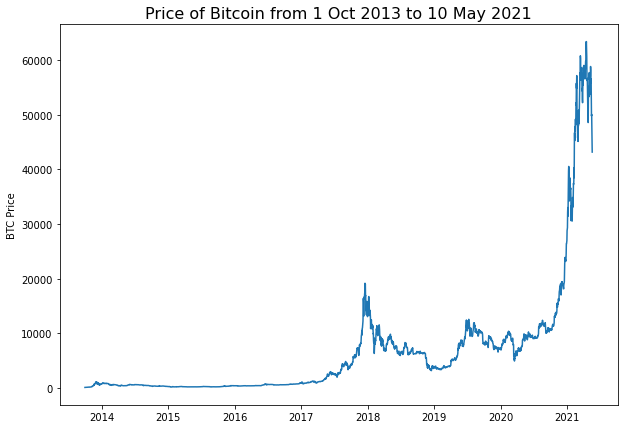

In [10]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (10,7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 10 May 2021", fontsize = 16)



## Fomat Dataset: Part 1

### Creating train and test splits with time series data(Bad way!)

In [11]:
# get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()
timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [12]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, # Dates
                                                    prices,
                                                    test_size =0.2,# Bitcoin prices
                                                    random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

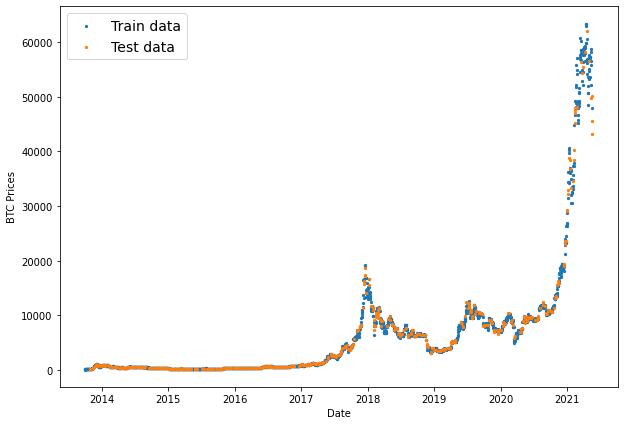

In [13]:
# Lets plot wrong train and test splits
plt.figure(figsize = (10,7))
plt.scatter(X_train, y_train, s = 5, label = "Train data")
plt.scatter(X_test,y_test, s =5, label ="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Prices")
plt.legend(fontsize = 14)
plt.show();

## Create train & test sets for time series(correct way!)  

Timeseries train & test sets:

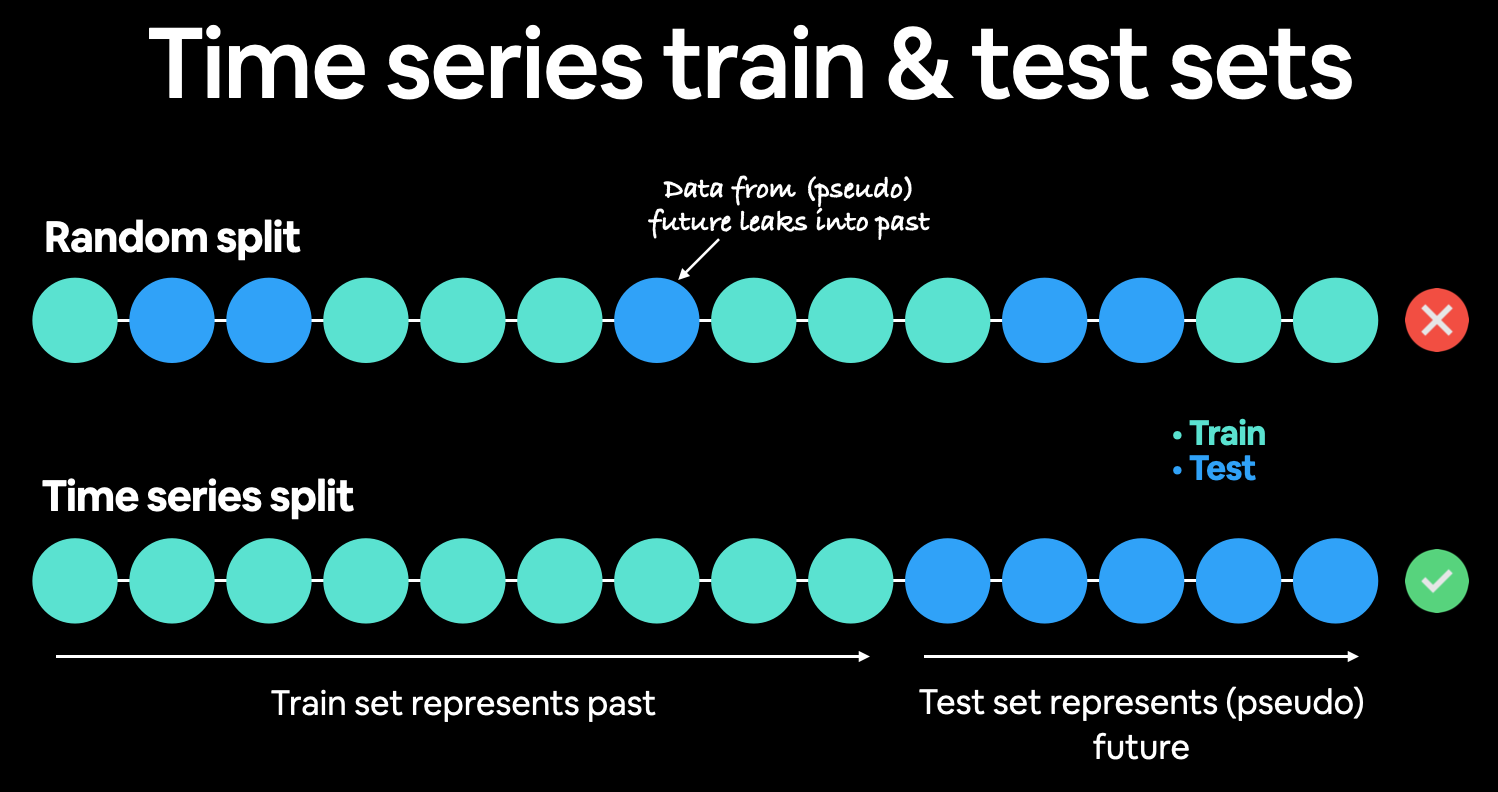  
Source: [ZTM Tensorflow course](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb)

In [14]:
# Create train and test splits the rightway for the time series data
split_size = int(0.8* len(prices)) # 80% train , 20% test you can change these values

# Creat train data splits (everything before split)
X_train , y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

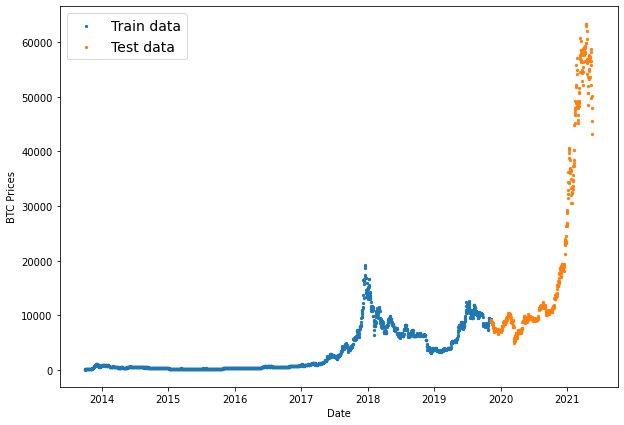

In [15]:
#plot the correctly made splits
plt.figure(figsize = (10,7))
plt.scatter(X_train, y_train, s = 5, label = "Train data")
plt.scatter(X_test,y_test, s =5, label ="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Prices")
plt.legend(fontsize = 14)
plt.show();

## Create a plotting function

Typing plotting code is tedious so let's make a function for that

In [17]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start = 0, end=None, label = None):
  """

  Plots timesteps (a series of points in time) against values 

  Parameters
  ----------
  timesteps : array of timestep values
  values : array of values across time
  format : style of plot, default = "."
  start : where to start the plot (setting a value will index from start of timesteps)
  end : where to end the plot (similar to start but for the end)
  label : label to show on plot about values, default None
  """

  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format ,label = label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize = 14) # make label bigger
  plt.grid(True)

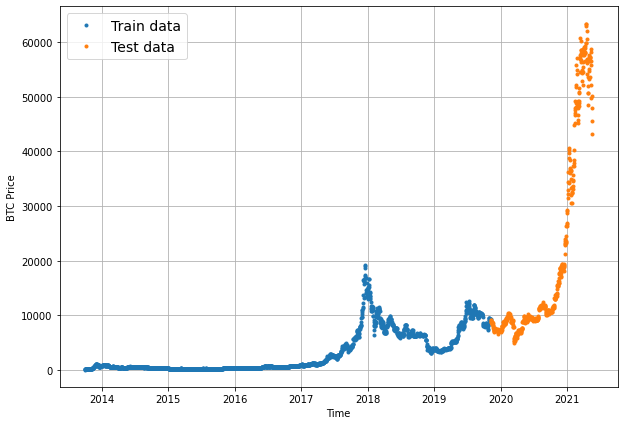

In [18]:
# Test our plotting function
plt.figure(figsize =(10,7)) # we create one figure to plot both plots
plot_time_series(timesteps = X_train, values = y_train, label = "Train data")
plot_time_series(timesteps = X_test, values = y_test, label = "Test data")

## Modelling experiments we will be running:  

Terms to be familiar with:
* **Horizon** = number of timesteps into the future we're going to predict.
* **window size** = number of timesteps we're going to use to predict **horizon**

| Experiment | Model |
| --- | --- |
| 0 | Naive Model(Baseline) |
| 1| Dense model (horizon = 1, window_size = 7) |
| 2 | Same as model 1 (horizon = 1, window_size = 30) |
| 3 | Same as model 1 (horizon = 7, window_size = 30) |
| 4 | Conv1D |
| 5 | LSTM |
| 6 | Same as model 1 (but with multivariate data) |
| 7 | N-BEATS Algorithm |
| 8 | Ensemble( multiple models stacked together) |
| 9 | Future prediction model |
| 10 | Same as model 1(but with turkey data introduced) |

## Model 0: Naive model (Baseline)  

The formula we use for this Naive model:

$$\hat{y}_{t} = y_{t-1}$$

In English:  
> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [19]:
y_test[:10]

array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
       8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
       8500.64355816, 8469.2608989 ])

In [20]:
# Create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

In [21]:
y_test[-10:]

array([58788.20967893, 58102.19142623, 55715.54665129, 56573.5554719 ,
       52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
       45604.61575361, 43144.47129086])

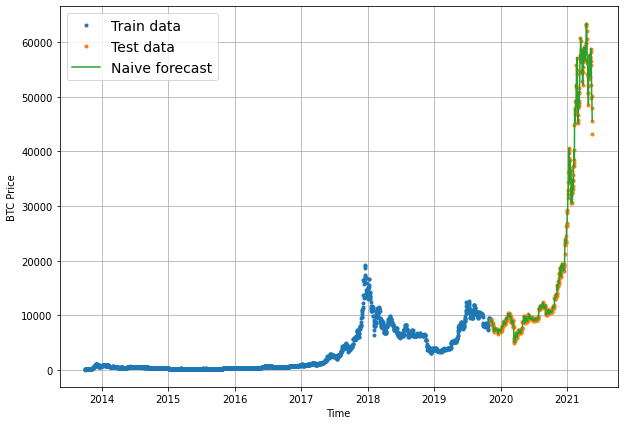

In [22]:
# Plot naive forecast
plt.figure(figsize = (10,7))
plot_time_series(timesteps= X_train, values = y_train, label= "Train data")
plot_time_series(timesteps = X_test, values = y_test, label = "Test data")
plot_time_series(timesteps = X_test[1:], values = naive_forecast, format="-", label = "Naive forecast")


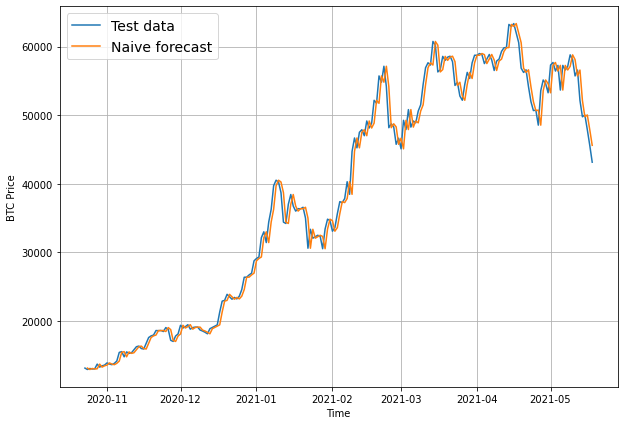

In [23]:
# Plot naive forecast
plt.figure(figsize = (10,7))
#plot_time_series(timesteps= X_train, values = y_train, label= "Train data")
plot_time_series(timesteps = X_test, values = y_test, format = "-", start = 350, label = "Test data")
plot_time_series(timesteps = X_test[1:], values = naive_forecast, format="-", start = 350, label = "Naive forecast")

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.  

We're predicting a number, so that means we have a form of a regression problem.  

Because we are working on a regression problem, we'll need some regression-like metrics.  

Common regression metrics:  
* MAE - Mean absolute error
* MSE - Mean squared error
*

The main thing we're evaluting here is: how do our model's forecasts(y_pred) compare against the 



These are metrics which can be used to compare time series values and forecasts that are on the same scale.

For example, Bitcoin historical prices in USD veresus Bitcoin forecast values in USD.

| Metric | Details | Code |
| ----- | ----- | ----- |
| **MAE** (mean absolute error) | Easy to interpret (a forecast is X amount different from actual amount). Forecast methods which minimises the MAE will lead to forecasts of the median. | [`tf.keras.metrics.mean_absolute_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanAbsoluteError) |
| **RMSE** (root mean square error) | Forecasts which minimise the RMSE lead to forecasts of the mean. | `tf.sqrt(`[`tf.keras.metrics.mean_square_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/RootMeanSquaredError)`)`|  

### Percentage errors

Percentage errors do not have units, this means they can be used to compare forecasts across different datasets.

| **Metric** | **Details** | **Code** |
| ----- | ----- | ----- |
| **MAPE** (mean absolute percentage error) | Most commonly used percentage error. May explode (not work) if `y=0`. | [`tf.keras.metrics.mean_absolute_percentage_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MAPE) | 
| **sMAPE** (symmetric mean absolute percentage error) | Recommended not to be used by [Forecasting: Principles and Practice](https://otexts.com/fpp3/accuracy.html#percentage-errors), though it is used in forecasting competitions. | Custom implementation |



### Scaled errors

Scaled errors are an alternative to percentage errors when comparing forecast performance across different time series.

| **Metric** | **Details** | **Code** |
| ----- | ----- | ----- |
| **MASE** (mean absolute scaled error). | MASE equals one for the naive forecast (or very close to one). A forecast which performs better than the naïve should get <1 MASE. | See sktime's [`mase_loss()`](https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16) |


### Implementing MASE Metric with TensorFlow

In [24]:
import tensorflow as tf

In [25]:
# MASE Implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality in data)

  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find the MAE of naive forecast (with no seasonality)
  mae_naive_no_seaon = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
  return mae/mae_naive_no_seaon

In [26]:
mean_absolute_scaled_error(y_true = y_test[1:], y_pred = naive_forecast).numpy()

0.9995699939182624

In [27]:
def evaluate_preds(y_true, y_pred):
  """
  Evaluates the predictions for different metrics and stores in dictionary
  """

  y_true = tf.cast(y_true, dtype = tf.float32)
  y_pred = tf.cast(y_pred, dtype = tf.float32)

  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  mae = tf.keras.metrics.mean_absolute_error(y_true,y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mse": mse.numpy(),
          "mae" : mae.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase" : mase.numpy()}

In [29]:
naive_results = evaluate_preds(y_true = y_test[1:], y_pred = naive_forecast)
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

## Other kinds of time series forecasting models which can be used for baselines and actual forecasts  

| **Model/Library Name** | **Resource** |
| ----- | ----- |
| Moving average | https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/ |
| ARIMA (Autoregression Integrated Moving Average) | https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ |
| sktime (Scikit-Learn for time series) | https://github.com/alan-turing-institute/sktime |
| TensorFlow Decision Forests (random forest, gradient boosting trees) | https://www.tensorflow.org/decision_forests |
| Facebook Kats (purpose-built forecasting and time series analysis library by Facebook) | https://github.com/facebookresearch/Kats | 
| LinkedIn Greykite (flexible, intuitive and fast forecasts) | https://github.com/linkedin/greykite |

## Format Data Part 2 : Windowing our dataset

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0,1,2,3,4,5,6] -> [7]
[1,2,3,4,5,6,7] -> [8]
[2,3,4,5,6,7,8] -> [9]
```

In [31]:
# What we want to do with our bitcoin data
print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]}")


We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [32]:
# Lets setup global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # Use the past week of Bitcoin data  to make the prediction

In [38]:
# Create function to label windowed data
def get_labelled_windows(x, horizon= HORIZON):
  """
  Creates label for windowed dataset

  E.g.: If horizon = 1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> (Output : [0, 1, 2, 3, 4, 5, 6] , [7])
  """

  return x[:, :-horizon], x[:, -horizon:]

In [39]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis = 0))
print(f" Window : {tf.squeeze(test_window).numpy()} - > Label: {tf.squeeze(test_label).numpy()}")

 Window : [1 2 3 4 5 6 7] - > Label: 8


**Note:**
* Window size(Input) : Number of time steps of historical data used to predict horizon.(Data)  
* Horizon(output): Number of time steps to predict into the future.(Label)  

We have go at way to label our windowed data. However this only works in small scale. We need a way to do the above across our entire time series.  

we could do this with python for loops, for large time series, that'd be quite slow.  

To speed things up, we'll leverage Numpy's array Indexing.  

Our function will:
1. Create a window step of specific window size
2. Use Numpy Indexing to create a 2D array of multiple window steps, for example: 
```
[[0, 1, 2, 3, 4, 5, 6],
 [1, 2, 3, 4, 5, 6, 7],
 [2, 3, 4, 5, 6, 7, 8]]
```  

3. Uses the 2D array of multiple window steps (from 2) to index on a target series(e.g.  the historical price of bitcoin)  
4. Uses our `get_labelled_winows()` function we created above to turn the window steps into windows with specified horizons.

In [42]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size = WINDOW_SIZE, horizon = HORIZON):
  """ 
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis = 0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)- (window_size+horizon - 1)), axis = 0).T
  #print(f"Window Indexes:\n {window_indexes, window_indexes.shape}")

  # 3. Index on the target array (a time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]
  #print(windowed_array)

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon = horizon)
  return windows, labels 


In [44]:
full_windows, full_labels = make_windows(prices, window_size = WINDOW_SIZE, horizon = HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [43]:
make_windows(prices, window_size= WINDOW_SIZE, horizon = HORIZON)

(array([[  123.65499   ,   125.455     ,   108.58483   , ...,
           121.33866   ,   120.65533   ,   121.795     ],
        [  125.455     ,   108.58483   ,   118.67466   , ...,
           120.65533   ,   121.795     ,   123.033     ],
        [  108.58483   ,   118.67466   ,   121.33866   , ...,
           121.795     ,   123.033     ,   124.049     ],
        ...,
        [58788.20967893, 58102.19142623, 55715.54665129, ...,
         52147.82118698, 49764.1320816 , 50032.69313676],
        [58102.19142623, 55715.54665129, 56573.5554719 , ...,
         49764.1320816 , 50032.69313676, 47885.62525472],
        [55715.54665129, 56573.5554719 , 52147.82118698, ...,
         50032.69313676, 47885.62525472, 45604.61575361]]),
 array([[  123.033     ],
        [  124.049     ],
        [  125.96116   ],
        ...,
        [47885.62525472],
        [45604.61575361],
        [43144.47129086]]))

In [45]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")


Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


**Note:**
There's a function which does similar to the above in tf.keras.preprocessing.
`tf.keras.preprocessing.time_series_dataset_from_array()`

## Turning windows into train and test sets

In [46]:
#make the train/test test splits
def make_train_test_splits(windows, labels, test_split= 0.2):
  """
  Splits matching pairs of windows and labels into train and test splits
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80%/20% train and test splits
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [47]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels, test_split= 0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [49]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [48]:
test_windows[:5], test_labels[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[8798.04205463],
        [9081.18687849],
        [8711.53433917],
        [8760.89271814],
        [8749.52059102]]))

In [51]:
# Check to see if train labels are the same before and after window split
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint  

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.  

We want to compare each of our models best perormance against the other model's best performance.

For example, if our modle performs the best on epoch 55 (but we're training for 100 epochs) , we want to load and evaluate the model saved on epoch 55.  

We can create modelling checkpoint callback using the following:
[Tensorflow docs Model checkpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint)

In [53]:
import os

# Create a function to implement a ModelCheckpoint call back with specific filename

def create_model_checkpoint(model_name, save_path = "model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(save_path, model_name),
                                            verbose = 0,
                                            save_best_only = True)